# **Building an Expected Goals (xG) Model**

## **Introduction**

Expected Goals (xG) is a statistical measure used in football analytics to estimate the likelihood of a shot resulting in a goal. This project aims to build an xG model using a dataset of football events, exploring the factors that influence the probability of scoring a goal. By analyzing features such as shot location, body part used, and the type of assist, we can derive meaningful insights and construct a predictive model.

---

## **Section 1: Data Understanding and Preparation**

The first step involves loading the events dataset (`events.csv`) into a Pandas DataFrame for analysis.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
events = pd.read_csv('events.csv')
print(events.head())

     id_odsp   id_event  sort_order  time  \
0  UFot0hit/  UFot0hit1           1     2   
1  UFot0hit/  UFot0hit2           2     4   
2  UFot0hit/  UFot0hit3           3     4   
3  UFot0hit/  UFot0hit4           4     7   
4  UFot0hit/  UFot0hit5           5     7   

                                                text  event_type  event_type2  \
0  Attempt missed. Mladen Petric (Hamburg) left f...           1         12.0   
1  Corner,  Borussia Dortmund. Conceded by Dennis...           2          NaN   
2  Corner,  Borussia Dortmund. Conceded by Heiko ...           2          NaN   
3           Foul by Sven Bender (Borussia Dortmund).           3          NaN   
4  Gokhan Tore (Hamburg) wins a free kick in the ...           8          NaN   

   side         event_team           opponent  ... player_in player_out  \
0     2         Hamburg SV  Borussia Dortmund  ...       NaN        NaN   
1     1  Borussia Dortmund         Hamburg SV  ...       NaN        NaN   
2     1  Borussia

Now we need to sort the data so it only includes relevant information to xG. First we need to include only shot events. Then only include necessary columns. We will also drop rows with missing values for simplicity.

In [54]:
shots = events[events['event_type'] == 1]
columns_to_keep = ['location', 'shot_place', 'shot_outcome', 'bodypart', 
                   'assist_method', 'situation', 'side', 'is_goal']
shots = shots[columns_to_keep]
shots = shots.dropna()
print(shots.head())
print(shots.count())

    location  shot_place  shot_outcome  bodypart  assist_method  situation  \
0        9.0         6.0           2.0       2.0              1        1.0   
11      15.0        13.0           2.0       1.0              1        1.0   
13       9.0         4.0           1.0       2.0              1        1.0   
14      15.0         2.0           3.0       1.0              0        1.0   
17      15.0         2.0           3.0       1.0              0        1.0   

    side  is_goal  
0      2        0  
11     1        0  
13     1        1  
14     1        0  
17     2        0  
location         227452
shot_place       227452
shot_outcome     227452
bodypart         227452
assist_method    227452
situation        227452
side             227452
is_goal          227452
dtype: int64


Now lets take a look at a couple graphs. One for where are most shots taken, and what is the outcome of the shots?

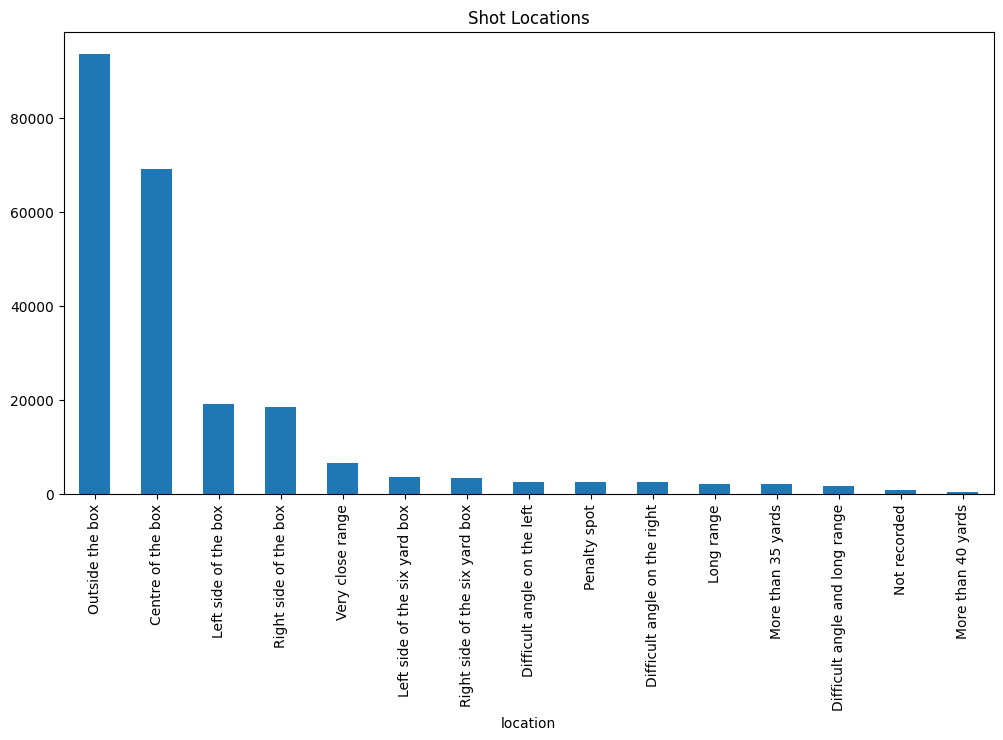

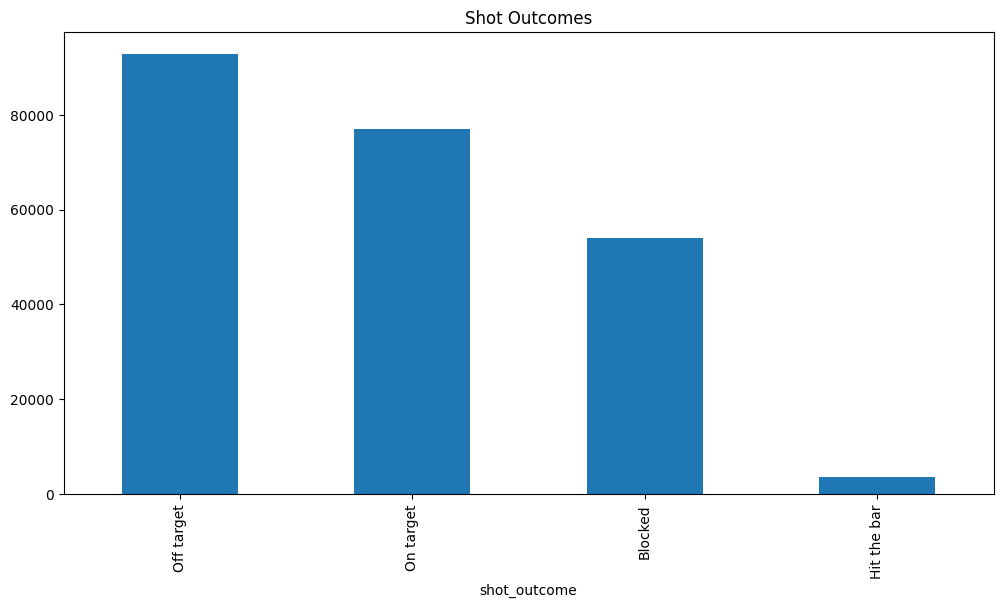

In [55]:
location_dict = {
    1: 'Attacking half', 2: 'Defensive half', 3: 'Centre of the box', 
    4: 'Left wing', 5: 'Right wing', 6: 'Difficult angle and long range', 
    7: 'Difficult angle on the left', 8: 'Difficult angle on the right',
    9: 'Left side of the box', 10: 'Left side of the six yard box',
    11: 'Right side of the box', 12: 'Right side of the six yard box',
    13: 'Very close range', 14: 'Penalty spot', 15: 'Outside the box', 
    16: 'Long range', 17: 'More than 35 yards', 18: 'More than 40 yards', 
    19: 'Not recorded'
}
shots['location'] = shots['location'].map(location_dict)
shots['location'].value_counts().plot(kind='bar', figsize=(12, 6), title="Shot Locations")
plt.show()

outcome_dict ={
    1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'
}
shots['shot_outcome'] = shots['shot_outcome'].map(outcome_dict)
shots['shot_outcome'].value_counts().plot(kind='bar', figsize=(12, 6), title="Shot Outcomes")
plt.show()

The first graph shows the frequency of the location of where each shot took place. The most common is outside the box with just under 100,000 shots. This is a little under half of all the shots taken in this dataset (approximately 229,000). The next highest is centre of the box with approximately 70,000 shots and then a drop off for the rest of the shots. The second graph displays the outcome of the shot, almost 100,000 of these shots were off target and almost 80,000 were almost on target. The number of blocked shots was approximately 60,000 too. 

# Section 2: Preparing the Dataset for xG Modeling

This section would involve cleaning, feature engineering, and ensuring that the dataset is structured in a way that can effectively contribute to the creation of an xG model.

Now let's approximate the distance each shot is from goal.

In [56]:
def calculate_distance(location):
    distance_map = {
        1: 50, 2: 50, 3: 10, 4: 15, 5: 15, 6: 30, 7: 25, 8: 25, 9: 12, 10: 5,  11: 12, 12: 5, 13: 3, 14: 11, 15: 20, 
        16: 25, 17: 35, 18: 40, 19: 25   
    }
    return distance_map.get(location, 25)

shots['distance_from_goal'] = shots['location'].apply(calculate_distance)
print(shots.head())

                location  shot_place shot_outcome  bodypart  assist_method  \
0   Left side of the box         6.0   Off target       2.0              1   
11       Outside the box        13.0   Off target       1.0              1   
13  Left side of the box         4.0    On target       2.0              1   
14       Outside the box         2.0      Blocked       1.0              0   
17       Outside the box         2.0      Blocked       1.0              0   

    situation  side  is_goal  distance_from_goal  
0         1.0     2        0                  25  
11        1.0     1        0                  25  
13        1.0     1        1                  25  
14        1.0     1        0                  25  
17        1.0     2        0                  25  


Now we want to select the features and target. The target variable will be is_goal, and the feature variables are location, shot_place, shot_outcome, bodypart, assist_method, situation, side, and distance_from_goal. We will then split the two into a feature matrix 'x' and a target vector 'y'.

In [57]:
feature_columns = ['location', 'shot_place', 'shot_outcome', 'bodypart', 
                   'assist_method', 'situation', 'side', 'distance_from_goal']
X = shots[feature_columns]
y = shots['is_goal']
print("Feature matrix (X):")
print(X.head())
print("\nTarget vector (y):")
print(y.head())


Feature matrix (X):
                location  shot_place shot_outcome  bodypart  assist_method  \
0   Left side of the box         6.0   Off target       2.0              1   
11       Outside the box        13.0   Off target       1.0              1   
13  Left side of the box         4.0    On target       2.0              1   
14       Outside the box         2.0      Blocked       1.0              0   
17       Outside the box         2.0      Blocked       1.0              0   

    situation  side  distance_from_goal  
0         1.0     2                  25  
11        1.0     1                  25  
13        1.0     1                  25  
14        1.0     1                  25  
17        1.0     2                  25  

Target vector (y):
0     0
11    0
13    1
14    0
17    0
Name: is_goal, dtype: int64


# Section 3: Building the xG model